In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
import glob

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [ ]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


['/content/drive/My Drive/Braynix/img/img3.png']
(512, 512)


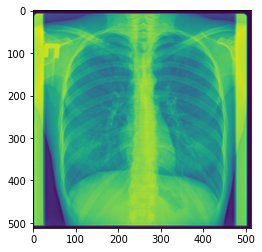

In [ ]:
####### Loading Image ###########

import os
path = "/content/drive/My Drive/Braynix/"

imgs_path = sorted([os.path.join(path, 'img', file) for file in os.listdir(path + "img") if file.endswith('.png')])
print(imgs_path)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = cv2.imread(imgs_path[0])
img = rgb2gray(img)

print(img.shape)
plt.imshow(img)

In [ ]:
########## Evalution Matrix ############

from math import log10, sqrt
import numpy as np

def PSNR(original, filtered):
    mse = np.mean((original - filtered) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


In [ ]:
############# Misc Functions #########

# Display one image
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()

    
# Display two images
def display_two(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

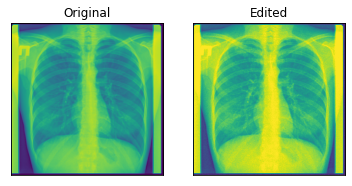

In [ ]:
########### Adding Noise ###############
def add_poisson_noise(img, lam):
    poisson = np.random.poisson(lam, np.shape(img))
    noisy_img = img + poisson
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

noise_img = add_poisson_noise(img,50)

display_two(img,noise_img)

For Weiner Filter Check this paper it has code too for understanding https://www.researchgate.net/publication/332574579_Image_Processing_Course_Project_Image_Filtering_with_Wiener_Filter_and_Median_Filter     

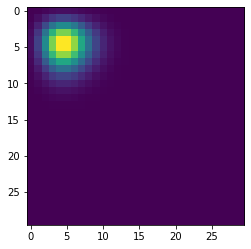

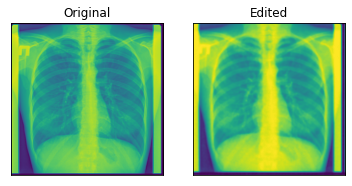

for poisson distribution PSNR:  5.213737550395491


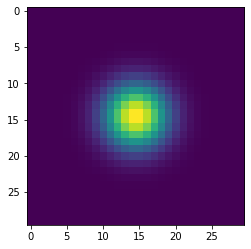

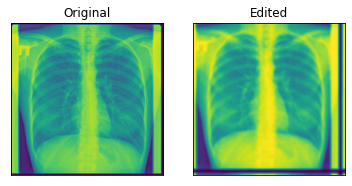

for Gaussian distribution PSNR:  5.188445114591764


In [ ]:
######### Weiner Filter ######### ( Statistical Approach MSE Optimization)

from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
from scipy.stats import poisson

def wiener_filter(img, kernel, K):
	kernel /= np.sum(kernel)  # Normalise
	dummy = np.copy(img)     
	dummy = fft2(dummy)   
	kernel = fft2(kernel, s = img.shape)
	kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
	dummy = dummy * kernel
	dummy = np.abs(ifft2(dummy))
	return dummy

def gaussian_kernel(kernel_size = 3, var = 1):
	h = gaussian(kernel_size, var).reshape(kernel_size, 1)
	h = np.dot(h, h.transpose())
	h /= np.sum(h)
	return h

def poisson_kernel(kernel_size = 5, mu = 1):
  x = np.arange(0, kernel_size)
  h = poisson.pmf(x,mu).reshape(kernel_size, 1)
  h = np.dot(h, h.transpose())
  h /= np.sum(h)
  return h

#### Degradation Function as Poisson #######

kernel = poisson_kernel(30,5)
plt.imshow(kernel)
plt.show()
filtered_img = wiener_filter(noise_img, kernel, K = 20)

display_two(img,filtered_img)
print("for poisson distribution PSNR: ",PSNR(img,filtered_img))

#### Degradation Function as Gaussian #######
kernel = gaussian_kernel(30,3)
plt.imshow(kernel)
plt.show()
filtered_img = wiener_filter(noise_img, kernel, K = 20)

display_two(img,filtered_img)
print("for Gaussian distribution PSNR: ",PSNR(img,filtered_img))

For Top and Bot hat filtering Check this video https://youtu.be/XKdz5DaT3Ps?t=348

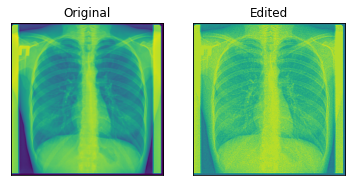

for Top and Bot Hat filtering PSNR:  13.665099491552455


In [ ]:
######### Top-Hat & Bot-Hat filtering ##########  ( Morphological Operation Approach)

def top_bot_hat_filter(img,kernel_size = 5):
  kernel = np.ones((kernel_size,kernel_size),np.uint8)
  fo = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
  fc = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

  T_hat = img - fo
  B_hat = fc - img

  filt_img = img + T_hat - B_hat
  return filt_img

filtered_img = top_bot_hat_filter(noise_img,5)
display_two(img,filtered_img)
print("for Top and Bot Hat filtering PSNR: ",PSNR(img,filtered_img))

In [ ]:
########## Homo-Morphic Filter #############   ( Logarithm based Approach )

